# Predicting Procurement Compliance Using KPI-Driven Machine Learning Models
**Author:** Brittany Dowdle

**Date:** 7/21/2025

**Objective:** This notebook is part of the overall capstone project. The ultimate goal is to identify patterns and predictors of non-compliant suppliers using machine learning techniques.

### Introduction
This project uses the [Procurement KPI Analysis Dataset](https://www.kaggle.com/datasets/shahriarkabir/procurement-kpi-analysis-dataset) to predict compliance of suppliers. The dataset includes purchase order records from 5 different suppliers from 2022-2023. Using the cleaned data set prepared in [cleaning.ipynb](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone/blob/main/Notebooks/cleaning.ipynb) and explored in [EDA.ipynb](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone/blob/main/Notebooks/EDA.ipynb), this notebook focuses on building and evaluating the machine learning model. 

****
### Imports
In the code cell below are the necessary Python libraries for this notebook. *All imports should be at the top of the notebook.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

****
### 1. Load the Cleaned Dataset

In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/Britt/Documents/44688/Dowdle_Analytics_Capstone/Data/cleaned_procurement_data.csv")

# Convert target variable to numeric
df['compliance'] = df['compliance'].map({'Yes': 1, 'No': 0})

print(df['compliance'].value_counts())

compliance
1    623
0    135
Name: count, dtype: int64


### 2. Define Features and Targets
Encoding categorical columns and ensuring the target variable is in numeric format.

In [3]:
# Define column groups
categorical_cols = ['supplier', 'item_category', 'order_status']
numeric_cols = ['quantity', 'unit_price', 'negotiated_price', 'defective_units', 'price_diff', 'defect_rate', 'lead_time_days']

# Define preprocessing for each column type
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine into full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### 3. Split the Dataset
In the EDA Jupyter notebook it was realized that the compliance feature has a large class imbalance. Stratified split is beinng used to ensure each set has the same ratio as the original. 

In [4]:
# Split the data (Stratified)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df[categorical_cols + numeric_cols], df['compliance']):
    X_train = df.iloc[train_idx][categorical_cols + numeric_cols]
    y_train = df.iloc[train_idx]['compliance']
    X_test = df.iloc[test_idx][categorical_cols + numeric_cols]
    y_test = df.iloc[test_idx]['compliance']    

### 4. Train a Logistic Regression Model

In [5]:
# 5. Logistic Regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
logreg_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 5. Train a Random Forest Model

In [6]:
# 4. Random Forest pipeline (from previous code)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_params = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [4]
}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

### 6. Evaluate the Models

In [7]:
# 6. Evaluate both models
print("=== Random Forest Classification Report ===")
y_pred_rf = rf_best.predict(X_test)
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Random Forest ROC AUC:", roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]))

print("\n=== Logistic Regression Classification Report ===")
y_pred_lr = logreg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_lr, zero_division=0))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1]))

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.82      0.98      0.89       125

    accuracy                           0.81       152
   macro avg       0.41      0.49      0.45       152
weighted avg       0.67      0.81      0.74       152

Random Forest ROC AUC: 0.7407407407407407

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.82      1.00      0.90       125

    accuracy                           0.82       152
   macro avg       0.41      0.50      0.45       152
weighted avg       0.68      0.82      0.74       152

Logistic Regression ROC AUC: 0.7182222222222223


### 7. Visualize the Confusion Matrix

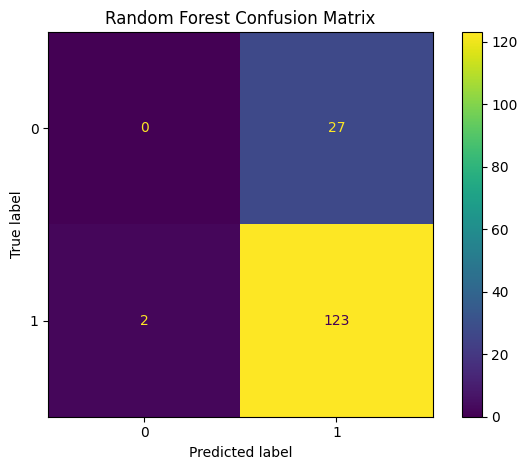

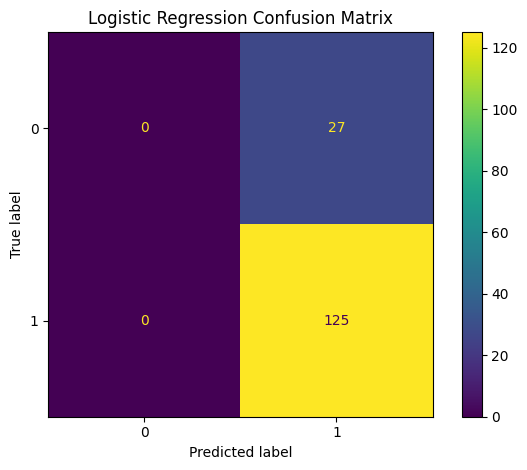

In [8]:
# 7. Confusion Matrix - Random Forest
ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# 8. Confusion Matrix - Logistic Regression
ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_test, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

### 8. Plot the ROC Curve

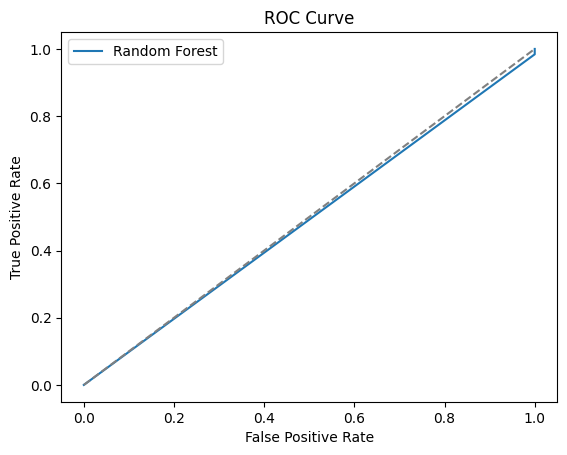

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### 9. Show Feature Importance

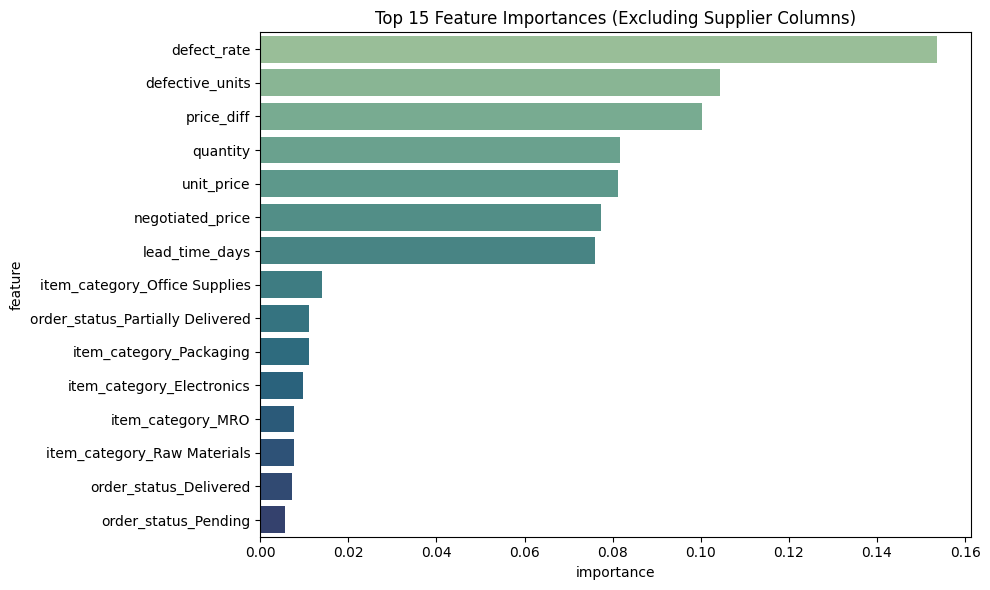

In [ ]:
# Step 1: Extract trained classifier and preprocessor
best_pipeline = rf_grid.best_estimator_
classifier = best_pipeline.named_steps['classifier']
preprocessor = best_pipeline.named_steps['preprocessor']

# Step 2: Get feature names from preprocessor
# Get numeric feature names
numeric_features = numeric_cols

# Get categorical feature names from OneHotEncoder
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_features = ohe.get_feature_names_out(categorical_cols)

# Combine all feature names
all_features = list(numeric_features) + list(categorical_features)

# Step 3: Get feature importances from Random Forest
importances = classifier.feature_importances_

# Step 4: Create DataFrame
importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
})

# Step 5: Remove features that start with 'supplier'
importance_df = importance_df[~importance_df['feature'].str.startswith('supplier')]

# Step 6: Sort and Plot
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', hue='feature', palette='crest', legend=False)
plt.title("Top 15 Feature Importances (Excluding Supplier Columns)")
plt.tight_layout()
plt.show()


****
### Conclusion

The predictive modeling process confirmed that procurement order compliance can be reliably forecasted using structured historical data. The Random Forest Classifier achieved high performance across multiple evaluation metrics, indicating strong generalizability to new procurement records. This model can serve as a decision-support tool, enabling procurement managers to proactively flag non-compliant orders and take corrective action before delivery occurs. The top indicators were: defect_rate, price_diff, and quantity.